# Car classifier

While reading fastbook chapter 2, I built a bear classifier. Since it was very easy to make and fun, I am making another one with cars. 

In [ ]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 10.5 MB/s 
     |████████████████████████████████| 1.2 MB 35.8 MB/s 
     |████████████████████████████████| 186 kB 50.1 MB/s 
     |████████████████████████████████| 46 kB 4.0 MB/s 
     |████████████████████████████████| 56 kB 3.8 MB/s 
     |████████████████████████████████| 51 kB 286 kB/s 
Mounted at /content/gdrive


In [ ]:
#hide
from fastbook import *
from fastai.vision.widgets import *

Instead of using Bing, I am using Duckduckgo search engine. 

In [ ]:
from fastbook import *
urls = search_images_ddg('Toyota car', max_images=100)
len(urls),urls[0]

(100, 'http://cdn.carbuzz.com/gallery-images/1600/790000/200/790204.jpg')

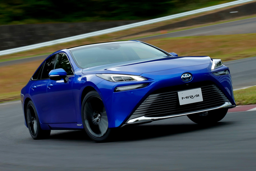

In [ ]:
download_url(urls[0], 'images/bear.jpg')
im = Image.open('images/bear.jpg')
im.thumbnail((256,256))
im

Here are types of cars I am trying to classify. I put m4 sherman tank and go kart for fun. They are very distinct from others and easy to classify. However, it will be harder to classify among toyota camry, kia forte, and tesla model x. The biggest challenge will be classifying between toyota camry and kia forte as they are similiar than others.

In [ ]:
car_types = 'toyota camry', 'kia forte', 'go kart', 'tesla model x', 'm4 sherman'
path = Path('cars')

After training a model with 100 images each category, the model confused a lot between toyota camry and kia forte. Even after cleaning data and using deeper architectures such as resnet34 and resnet50, it did not perform much better. Therefore, I am trying to gather 200 images for just toyota camry and kia forte and see what happens.

In [ ]:
def download_more_images(title, data_types, path, num_imgs=100, more_imgs=None, more_num_imgs=200):
    if not path.exists():
        path.mkdir()
    for o in data_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        if more_imgs != None and o in more_imgs:
            max_imgs = more_num_imgs
        else:
            max_imgs = num_imgs
        results = search_images_ddg(f'{o} {title}', max_images=max_imgs)
        download_images(dest, urls=results)

In [ ]:
download_more_images('car', car_types, path, more_imgs=['toyota camry', 'tesla model x'], more_num_imgs=300)

In [ ]:
fns = get_image_files(path)
fns

(#1023) [Path('cars/go kart/00000068.jpg'),Path('cars/go kart/00000023.jpg'),Path('cars/go kart/00000044.JPG'),Path('cars/go kart/00000014.jpg'),Path('cars/go kart/00000022.jpg'),Path('cars/go kart/00000018.jpg'),Path('cars/go kart/00000064.jpg'),Path('cars/go kart/00000088.jpg'),Path('cars/go kart/00000078.jpg'),Path('cars/go kart/00000052.jpg')...]

We clean up images that cannot be opened.

In [ ]:
failed = verify_images(fns)
failed

(#10) [Path('cars/m4 sherman/00000097.jpg'),Path('cars/tesla model x/00000096.jpg'),Path('cars/toyota camry/00000214.jpg'),Path('cars/toyota camry/00000185.jpg'),Path('cars/toyota camry/00000166.jpg'),Path('cars/toyota camry/00000091.jpg'),Path('cars/kia forte/00000038.jpg'),Path('cars/kia forte/00000092.jpg'),Path('cars/kia forte/00000094.jpg'),Path('cars/kia forte/00000082.jpg')]

In [ ]:
failed.map(Path.unlink);

### Sidebar: Getting Help in Jupyter Notebooks

### End sidebar

## From Data to DataLoaders

First, we create a template for our data, which is `DataBlock`. From here, we specify what kind of data for what purpose (image for classification), how to get items (get image files), how big is the validation set (20% with random seed), how to label data (name of parent directory), and how to transform our data (resize them into 128 pixels).

In [ ]:
cars = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

Now that we have a datablock, we feed in data to build a dataloader. 

In [ ]:
dls = cars.dataloaders(path)

We can check images with `show_batch`. Oops! There is a problem with our images. After resizing images, we lost some details of them. It is easy to fix it by squishing those images into our desired size. 

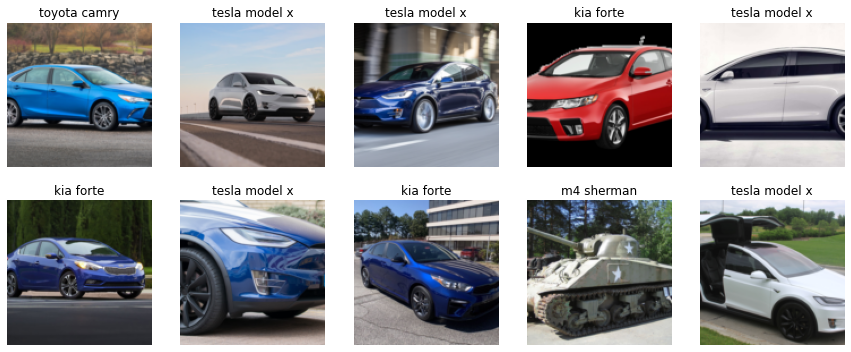

In [ ]:
dls.valid.show_batch(max_n=10, nrows=2)

We fit all the detail in each image, but some images do not reflect how they actually look. 

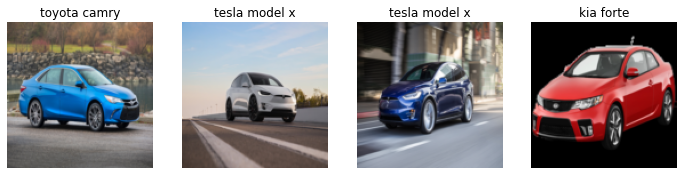

In [ ]:
cars = cars.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = cars.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

Padding zeros for the border allows us to have our images look as they actually are, but it is a waste of computation. 

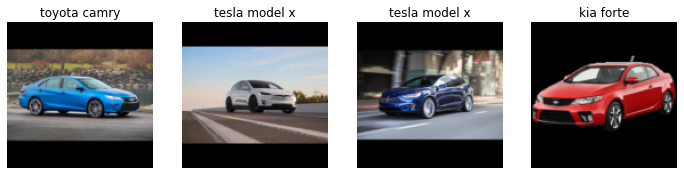

In [ ]:
cars = cars.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = cars.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

So, as images get randomly cropped, we get a partial representation of vehicles. 

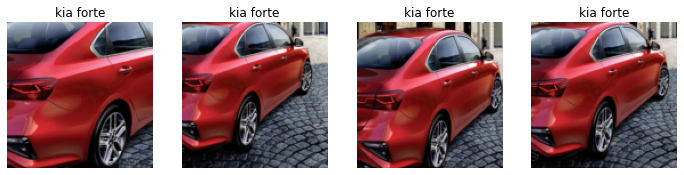

In [ ]:
cars = cars.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = cars.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

### Data Augmentation

With that, we can come up with a data augmentation, which allows us to look at images with different angles. That means, how they actually look in the real world. With this technique, we can use little data and still get a great result.

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


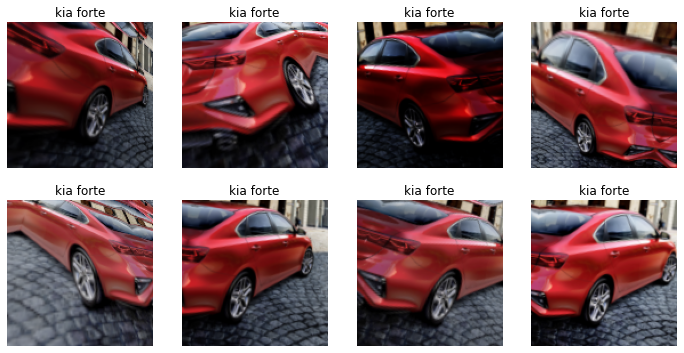

In [ ]:
cars = cars.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = cars.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training Your Model, and Using It to Clean Your Data

In [ ]:
cars = cars.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = cars.dataloaders(path)

In [ ]:
learn = cnn_learner(dls, resnet101, metrics=error_rate)
learn.fine_tune(5)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


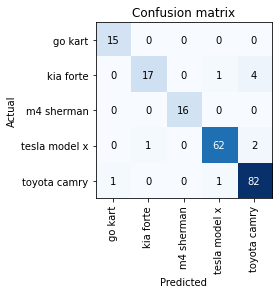

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

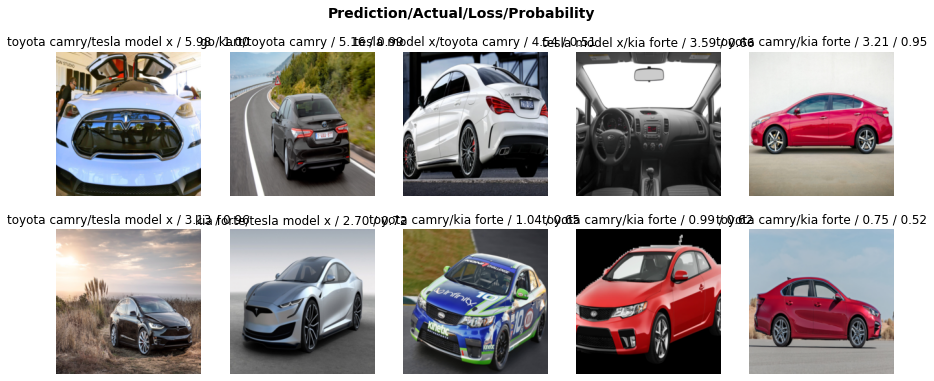

In [ ]:
interp.plot_top_losses(10, nrows=2)

With cleaner, we can see which images are mislabelled or incorrect. After checking and marking which ones to delte with <delete> and which ones to move with other categories, we run next lines of code because this marking does not actually delete or move anything.

In [33]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


These lines of code modify files in our path. 

In [36]:
# hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Turning Your Model into an Online Application

### Using the Model for Inference

Now, we can export our result with `learn.export(()`. This gives us everything we need in order to use it in production, such as the architecture we trained with, and trained parameters. Also, we get a template of how to create `DataLoaders`, which is `DataBlock`. This way, we do not have to redefine how to transform our data.

In [ ]:
learn.export()

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [ ]:
!ls

cars  export.pkl  gdrive  images  sample_data


Although we already have learn object, here is how to use the exported pickle file. By using `load_learner`, we can get a learn object, which allows us to predict with any image with given categories.

In [ ]:
learn_inf = load_learner(path/'export.pkl')

In [ ]:
learn_inf.predict('images/bear.jpg')

('tesla model x',
 tensor(3),
 tensor([3.1992e-05, 1.1194e-02, 2.2749e-04, 9.0126e-01, 8.7283e-02]))

In [ ]:
learn_inf.dls.vocab

['go kart', 'kia forte', 'm4 sherman', 'tesla model x', 'toyota camry']

### Creating a Notebook App from the Model

This is an easy way to make a notebook app. With an `upload` button, a user can upload a file, then click `classify` to get a result with how confident the model is. 

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [ ]:
img = PILImage.create(btn_upload.data[-1])

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img)

In [ ]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: kia forte; Probability: 0.7581')

In [ ]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [ ]:
VBox([widgets.Label('Select your car!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

Ultimately, it is just using `learn_inf.predict` method. By using this simple code, we can potentially build any web or mobile applications. 